In [1]:
from dotenv import load_dotenv
from pptx import Presentation

load_dotenv()

True

In [2]:
import operator
import os
import random
from typing import Annotated, Sequence, TypedDict

from IPython.display import Image
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import (BaseMessage, HumanMessage, SystemMessage,
                                     ToolMessage)
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict

In [37]:
search_tool = TavilySearchResults(max_results=2)

tools = [search_tool]

llm = ChatOpenAI()
llm_with_tools = llm.bind_tools(tools)


In [57]:

class State(TypedDict):
    messages: Annotated[list, add_messages]
    bullet_points: list[str]


def chatbot(state: State):
    print("--> chatbot")
    messages = state["messages"]
    result = llm_with_tools.invoke(messages)
    return {"messages": [result]}




search_tool_node = ToolNode(tools=[search_tool])


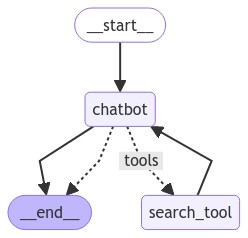

In [58]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("search_tool", search_tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "search_tool", "__end__": END},
)
graph_builder.add_edge("search_tool", "chatbot")

graph_builder.set_entry_point("chatbot")
app = graph_builder.compile()

Image(app.get_graph().draw_mermaid_png())


In [59]:
r = app.invoke({"messages": [
    SystemMessage("""You are a powerpoint creater writing bullet points for a slide about a specific topic. 
                  You use tools to do this."""),
    HumanMessage("modern danish history"),
]})

print(r)

--> chatbot
--> chatbot
{'messages': [SystemMessage(content='You are a powerpoint creater writing bullet points for a slide about a specific topic. \n                  You use tools to do this. You should create just one bullet point for the slide.', id='4fa30e41-7b6c-4746-8d53-0e258866ab7e'), HumanMessage(content='modern danish history', id='4338e23c-1758-4b67-bdde-2ddad01a60a9'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4bCdQSLfCgrRbCv5QhpkihRe', 'function': {'arguments': '{"query":"modern Danish history"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 123, 'total_tokens': 143}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0bc10792-d4d2-4927-ac57-36d2b878d3d6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'modern Danish history'}, 'id': 'call_4bCdQSLfCgrRbCv5Qhpk

In [61]:
for msg in r.get("messages"):
    print(type(msg))
    print(msg)
    print("---")


<class 'langchain_core.messages.system.SystemMessage'>
content='You are a powerpoint creater writing bullet points for a slide about a specific topic. \n                  You use tools to do this. You should create just one bullet point for the slide.' id='4fa30e41-7b6c-4746-8d53-0e258866ab7e'
---
<class 'langchain_core.messages.human.HumanMessage'>
content='modern danish history' id='4338e23c-1758-4b67-bdde-2ddad01a60a9'
---
<class 'langchain_core.messages.ai.AIMessage'>
content='' additional_kwargs={'tool_calls': [{'id': 'call_4bCdQSLfCgrRbCv5QhpkihRe', 'function': {'arguments': '{"query":"modern Danish history"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 123, 'total_tokens': 143}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-0bc10792-d4d2-4927-ac57-36d2b878d3d6-0' tool_calls=[{'name': 'tavily_search_results_json'

In [62]:

last_message = r.get("messages")[-1]
print(last_message.content)

- The National Museum's department of Modern Danish History covers Danish history from 1660 until today, ensuring all social groups in Denmark recognize their own history in the collection. (Source: [National Museum](https://en.natmus.dk/organisation/management-secretariat-and-research-administration/modern-history-and-world-cultures/modern-danish-history/))
